# Visualizing the SpaceX Tesla Roadster trip to Mars

In [1]:
from astropy.time import Time

from astropy.coordinates import solar_system_ephemeris
solar_system_ephemeris.set("jpl")

from poliastro.bodies import *
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter, plot

EPOCH = Time("2018-02-18 12:00:00", scale="tdb")

In [2]:
import callhorizons

from astropy.coordinates import ICRS, CartesianRepresentation, CartesianDifferential
from poliastro.frames import HeliocentricEclipticJ2000

def get_roadster_orbit(epoch):
    # Get orbital data
    roadster = callhorizons.query("SpaceX Roadster", smallbody=False)
    roadster.set_discreteepochs([epoch.jd])
    roadster.get_elements(center="500@10")

    # Create Orbit object to do conversions
    roadster_eclip = Orbit.from_classical(
        Sun,
        roadster['a'][0] * u.au,
        roadster['e'][0] * u.one,
        roadster['incl'][0] * u.deg,
        roadster['node'][0] * u.deg,
        roadster['argper'][0] * u.deg,
        roadster['trueanomaly'][0] * u.deg,
        epoch
    )

    # Convert to ICRS
    roadster_eclip_coords = HeliocentricEclipticJ2000(
        x=roadster_eclip.r[0], y=roadster_eclip.r[1], z=roadster_eclip.r[2],
        v_x=roadster_eclip.v[0], v_y=roadster_eclip.v[1], v_z=roadster_eclip.v[2],
        representation=CartesianRepresentation,
        differential_type=CartesianDifferential,
        obstime=epoch
    )

    roadster_icrs_coords = roadster_eclip_coords.transform_to(ICRS)
    roadster_icrs_coords.representation = CartesianRepresentation

    # Create final orbit
    roadster_icrs = Orbit.from_vectors(
        Sun,
        r=[roadster_icrs_coords.x, roadster_icrs_coords.y, roadster_icrs_coords.z] * u.km,
        v=[roadster_icrs_coords.v_x, roadster_icrs_coords.v_y, roadster_icrs_coords.v_z] * (u.km / u.s),
        epoch=epoch
    )

    return roadster_icrs

In [3]:
roadster = get_roadster_orbit(EPOCH)
roadster

1 x 2 AU x 24.2 deg orbit around Sun (☉)

In [4]:
from poliastro.plotting import plot_solar_system

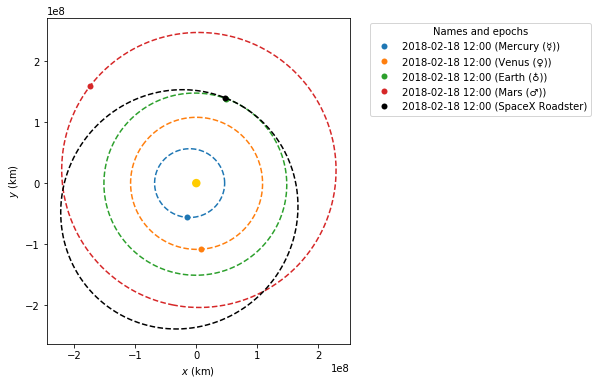

In [5]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot(roadster, label="SpaceX Roadster", color='k')

In [6]:
from poliastro.plotting import OrbitPlotter3D

from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

In [7]:
frame = OrbitPlotter3D()

frame.plot(Orbit.from_body_ephem(Earth), label=Earth)
frame.plot(Orbit.from_body_ephem(Mars), label=Mars)
frame.plot(roadster, label="SpaceX Roadster", color='black')

frame.set_view(30 * u.deg, -100 * u.deg, 2 * u.km)
frame.show()